# After Lesson Update:

## 1. Added the ability to replace noise in connect components with the dominant class.

## 2. Added the ability to remove small components.



### Accuracy improved: 0.9760696308724832 => 0.989147557792692

# **Before**

---


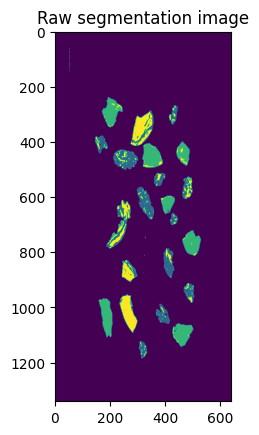

---
# **After**
---
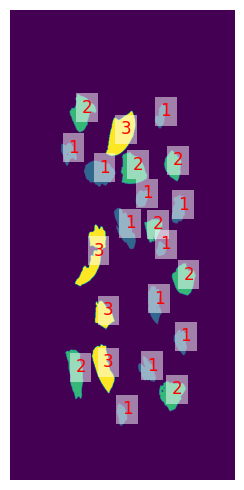

In [229]:
!pip install spectral
from spectral import envi # load envi module

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [230]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/MyDrive/walnut_hsi

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/MyDrive/walnut_hsi


In [231]:
file_name = r"/gdrive/MyDrive/walnut_hsi/walnut_RT.hdr" # or use 'os.listdir' to list files inside the folder
data = envi.open(file_name) # if .hdr and .raw has different name, use envi.open(HDR_NAME, RAW_NAME)

/usr/local/lib/python3.10/dist-packages/spectral/io/envi.py:175: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)


In [232]:
print(type(data))
print(data)

<class 'spectral.io.bilfile.BilFile'>
	Data Source:   '/gdrive/MyDrive/walnut_hsi/walnut_RT.raw'
	# Rows:           1341
	# Samples:         640
	# Bands:           224
	Interleave:        BIL
	Quantization:  32 bits
	Data format:   float32


In [233]:
np_data = data.asarray() # convert to numpy
print(type(np_data))
print(np_data.shape) # (row, sample, band)
print(np.count_nonzero(np.isnan(np_data)))

<class 'numpy.memmap'>
(1341, 640, 224)
0


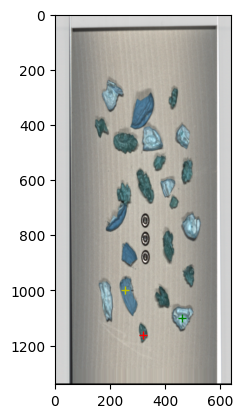

In [234]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots()

default_bands = [192, 134, 76] # index the (R, G, B)
false_color_data = np_data[..., default_bands]

# normalize data
d_max = np.max(false_color_data)
d_min = np.min(false_color_data)
normaled_data = (false_color_data - d_min) / (d_max - d_min)

almond = (1160,320)
walnut_inner = (1100,460)
walnut_outer = (1000,255)

ax.plot(almond[1], almond[0], marker='+', color='r')
ax.plot(walnut_inner[1], walnut_inner[0], marker='+', color='g')
ax.plot(walnut_outer[1], walnut_outer[0], marker='+', color='y')


ax.imshow(normaled_data) # view the single band and show as gray-scale image

In [235]:
import numpy as np

def cosine_similarity(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

def get_similarity_to_point(img, target_pixel):
    target_vector = img[target_pixel[0], target_pixel[1]]
    img_norm = np.linalg.norm(img, axis=2, keepdims=False)
    target_norm = np.linalg.norm(target_vector)
    dot_product = np.tensordot(img, target_vector, axes=(-1, -1))
    denominator = img_norm * target_norm
    denominator[np.where(denominator == 0.0)] = 0.00000001
    result_img = dot_product / denominator
    normalized_result_img = (result_img - np.min(result_img)) / (np.max(result_img) - np.min(result_img))
    print(f'dot_product, {np.count_nonzero(np.isnan(dot_product))}')
    print(f'img_norm,{np.count_nonzero(np.isnan(img_norm))}')
    print(f'target_norm, {np.count_nonzero(np.isnan(target_norm))}')
    print(f'is zero: {denominator.size - np.count_nonzero(denominator)}')
    return normalized_result_img

dot_product, 0
img_norm,0
target_norm, 0
is zero: 0


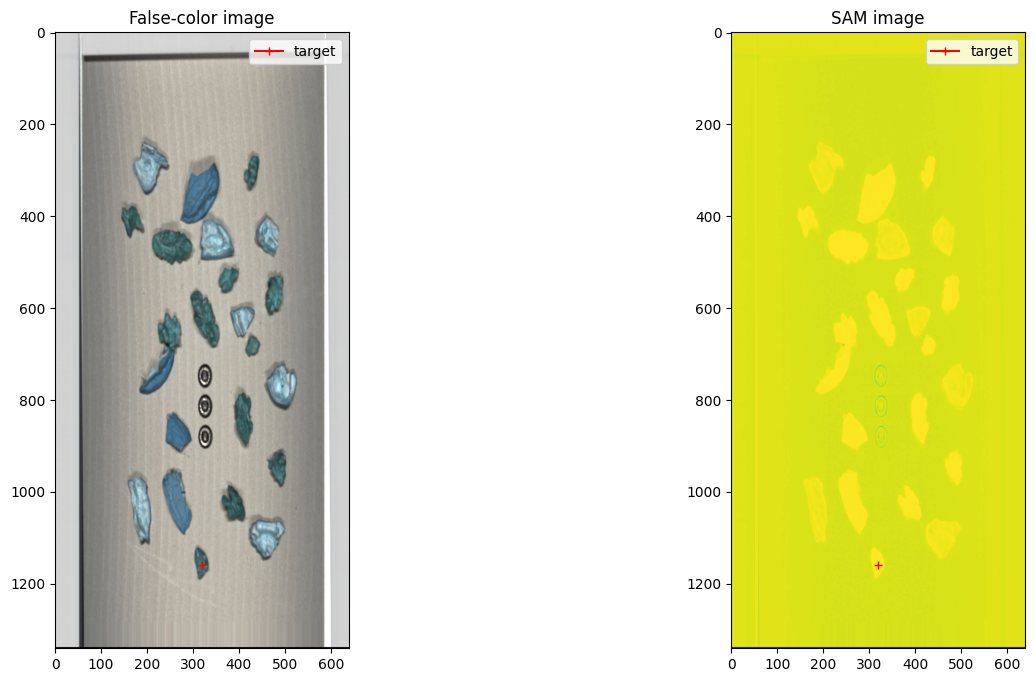

In [236]:
almond_sam = get_similarity_to_point(np_data, almond)
fig, ax = plt.subplots(1,2, figsize=(16, 8))
ax[0].set_title("False-color image")
ax[0].imshow(normaled_data)
ax[0].plot(almond[1], almond[0], marker='+', color='r', label='target')
ax[0].legend()
ax[1].set_title("SAM image")
ax[1].imshow(almond_sam)
ax[1].plot(almond[1], almond[0], marker='+', color='r', label='target')
ax[1].legend()

dot_product, 0
img_norm,0
target_norm, 0
is zero: 0


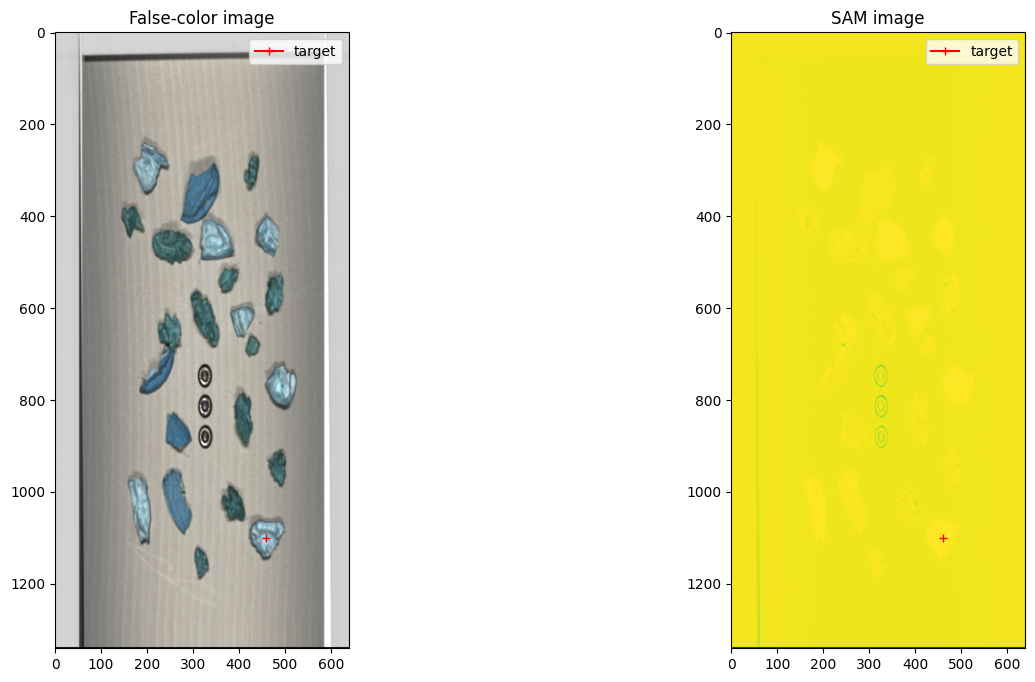

In [237]:
walnut_inner_sam = get_similarity_to_point(np_data, walnut_inner)
fig, ax = plt.subplots(1,2, figsize=(16, 8))
ax[0].set_title("False-color image")
ax[0].imshow(normaled_data)
ax[0].plot(walnut_inner[1], walnut_inner[0], marker='+', color='r', label='target')
ax[0].legend()
ax[1].set_title("SAM image")
ax[1].imshow(walnut_inner_sam)
ax[1].plot(walnut_inner[1], walnut_inner[0], marker='+', color='r', label='target')
ax[1].legend()

dot_product, 0
img_norm,0
target_norm, 0
is zero: 0


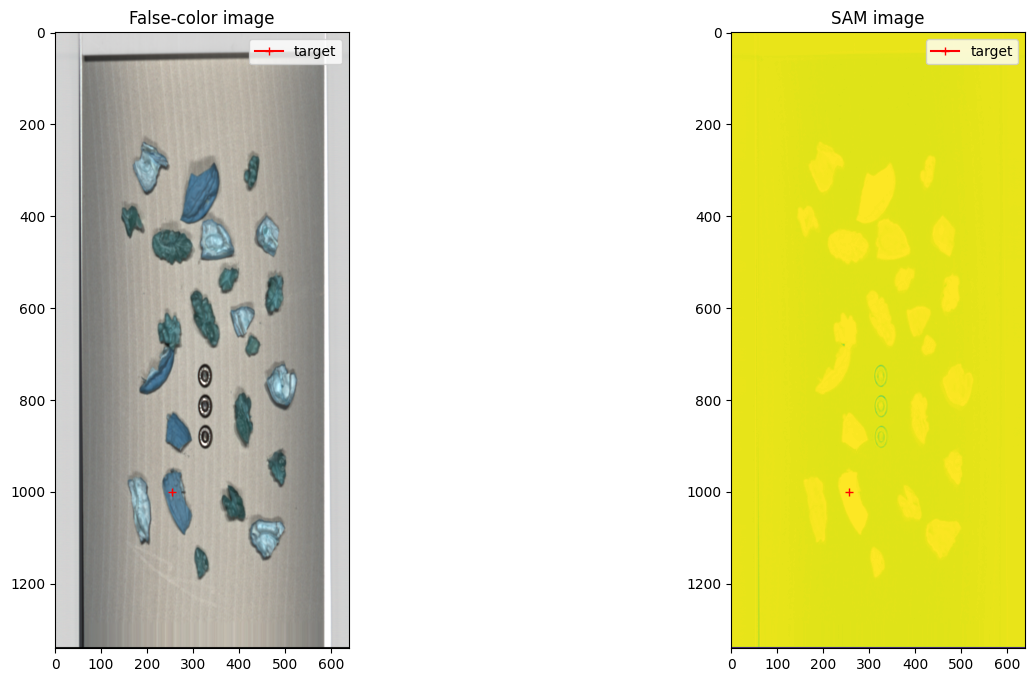

In [238]:
walnut_outer_sam = get_similarity_to_point(np_data, walnut_outer)
fig, ax = plt.subplots(1,2, figsize=(16, 8))
ax[0].set_title("False-color image")
ax[0].imshow(normaled_data)
ax[0].plot(walnut_outer[1], walnut_outer[0], marker='+', color='r', label='target')
ax[0].legend()
ax[1].set_title("SAM image")
ax[1].imshow(walnut_outer_sam)
ax[1].plot(walnut_outer[1], walnut_outer[0], marker='+', color='r', label='target')
ax[1].legend()

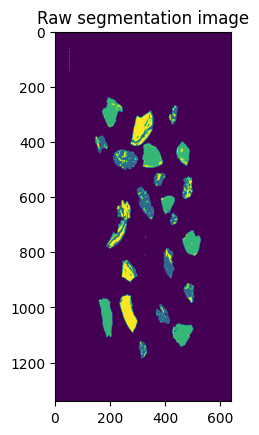

In [239]:
seg_img = np.empty(np_data.shape[0:2], dtype='int32')
colors = np.array([1, 2, 3])
# Stack the samples along the last axis
samples = np.stack((almond_sam, walnut_inner_sam, walnut_outer_sam), axis=-1)
# Find the maximum value along the last axis
max_vals = np.max(samples, axis=2)
# Find the index of the maximum value (seg_class) along the last axis
seg_class = np.argmax(samples, axis=2)
# Assign colors to each class
seg_img = colors[seg_class]
seg_img[max_vals <= 0.99] = 0
plt.title('Raw segmentation image')
plt.imshow(seg_img)

In [240]:
from scipy.ndimage import label, generate_binary_structure

def find_connected_components(segmentation, background_value=0):
    # Create a binary mask where non-background pixels are set to 1
    non_background_mask = (segmentation != background_value).astype(int)

    # Find connected components
    connected_components, _ = label(non_background_mask, structure=generate_binary_structure(2,2))

    return connected_components


In [241]:
import numpy as np

def remove_small_components(connected_components, min_area, background_value=0):
    num_components = connected_components.max()
    result = connected_components.copy()

    for comp_id in range(1, num_components + 1):
        component_mask = connected_components == comp_id
        component_area = np.sum(component_mask)

        if component_area < min_area:
            result[component_mask] = background_value

    return result

In [242]:
def replace_classes_with_dominant_class(segmentation, connected_components):

    num_components = connected_components.max()
    dominant_classes = {}

    # Find the most dominant class for each connected component
    for comp_id in range(1, num_components + 1):
        component_mask = connected_components == comp_id
        component_classes = segmentation[component_mask]

        # Find the most common class in the component
        if component_classes.size > 0:
          most_common_class = np.bincount(component_classes).argmax()
          dominant_classes[comp_id] = most_common_class

    # Replace classes with their most dominant class
    result = segmentation.copy()
    for comp_id, dominant_class in dominant_classes.items():
        result[connected_components == comp_id] = dominant_class

    return result

In [243]:
def find_centroids(connected_components):
    num_components = connected_components.max()
    centroids = {}

    for comp_id in range(1, num_components + 1):
        component_mask = connected_components == comp_id
        rows, cols = np.where(component_mask)

        # Calculate the centroid (center point) of the component
        if rows.size > 0 and cols.size > 0:
          centroid_row = int(round(rows.mean()))
          centroid_col = int(round(cols.mean()))

          centroids[comp_id] = (centroid_row, centroid_col)

    return centroids

In [244]:
import numpy as np

def update_segmentation_with_filtered_components(segmentation, connected_components, filtered_components):
    removed_components_mask = (connected_components != filtered_components) & (connected_components != 0)
    updated_segmentation = segmentation.copy()
    updated_segmentation[removed_components_mask] = 0

    return updated_segmentation

In [245]:
def plot_image_with_centroids(image, centroids):
    plt.figure(figsize=(10, 5))
    plt.imshow(image, cmap='viridis')

    for comp_id, (row, col) in centroids.items():
        class_value = image[row, col]
        plt.text(col, row, str(class_value), color='red', fontsize=12,
                 bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))
    plt.axis('off')
    plt.tight_layout()
    plt.show()

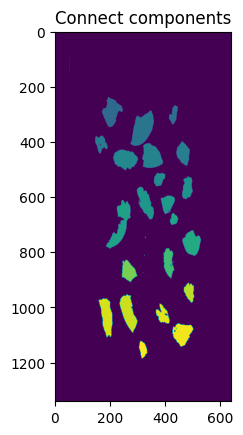

In [246]:
connected_components = find_connected_components(seg_img)
plt.title('Connect components')
plt.imshow(connected_components)

In [247]:
seg_img.shape

(1341, 640)

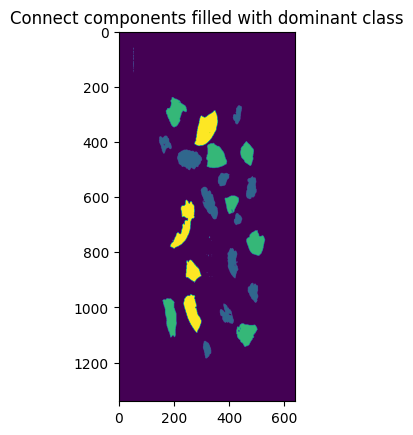

In [248]:
final_seg_img = replace_classes_with_dominant_class(seg_img, connected_components)
plt.title('Connect components filled with dominant class')
plt.imshow(final_seg_img)

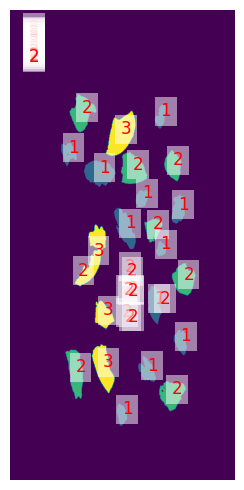

In [249]:
plot_image_with_centroids(final_seg_img, find_centroids(connected_components))
# Not Ideal, too much noise.

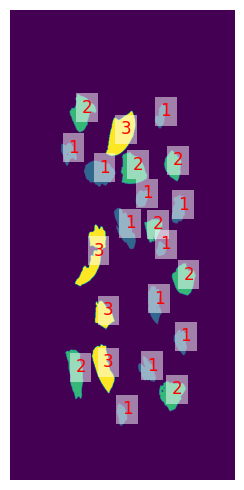

In [250]:
# Remove small components, they are noise.
filtered_small_components = remove_small_components(connected_components, min_area=100)
updated_segmentation = update_segmentation_with_filtered_components(seg_img, connected_components, filtered_small_components)
filtered_final_seg_img = replace_classes_with_dominant_class(updated_segmentation, filtered_small_components)
plot_image_with_centroids(filtered_final_seg_img, find_centroids(filtered_small_components))

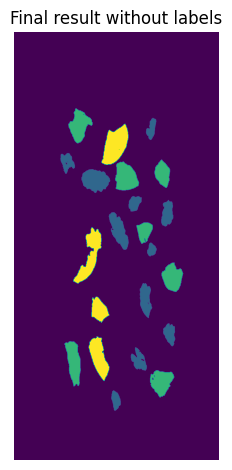

In [251]:
plt.imshow(filtered_final_seg_img, cmap='viridis')
plt.title('Final result without labels')
plt.axis('off')
plt.tight_layout()
plt.show()

In [252]:
import numpy as np
from sklearn.metrics import accuracy_score
import os
from google.colab import files

pred = filtered_final_seg_img # place your classification result array in here

!wget -N 'https://github.com/qaz10102030/test/raw/master/ground-truth.npy'
true = np.load('./ground-truth.npy')

assert pred.shape == true.shape

print(accuracy_score(true.reshape(-1), pred.reshape(-1)))

--2023-06-14 09:53:24--  https://github.com/qaz10102030/test/raw/master/ground-truth.npy
Resolving github.com (github.com)... 20.27.177.113
Connecting to github.com (github.com)|20.27.177.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/qaz10102030/test/master/ground-truth.npy [following]
--2023-06-14 09:53:24--  https://raw.githubusercontent.com/qaz10102030/test/master/ground-truth.npy
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3433088 (3.3M) [application/octet-stream]
Saving to: ‘ground-truth.npy’

ground-truth.npy    100%[===================>]   3.27M  18.7MB/s    in 0.2s    

Last-modified header missing -- time-stamps turned off.
2023-06-14 09:53:25 (18.7 MB/s) - ‘ground-truth.npy’